# Distracted Driver Detection

## Include Dependency

In [1]:
#import

import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import statistics
import random
import time
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold,ShuffleSplit
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,Callback
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from scipy.misc import imread, imresize

from keras.layers import *
from keras.models import Model
import h5py


/home/john/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## Import data

Define a load_train function to load the image from the file path of the data

In [2]:

def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( '..','capserver','data','imgs', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2_resize(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers

## Data Exploratory

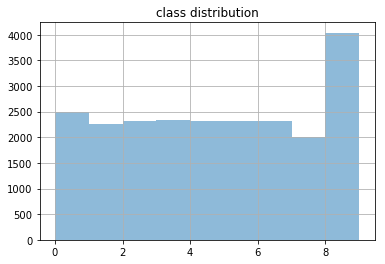

In [48]:
img_list = pd.read_csv('../capserver/data/driver_imgs_list.csv')
img_list['class_type'] = img_list['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure()
img_list.hist('class_type',alpha=0.5,layout=(1,1),bins=9)
plt.title('class distribution')
plt.draw()
plt.show()

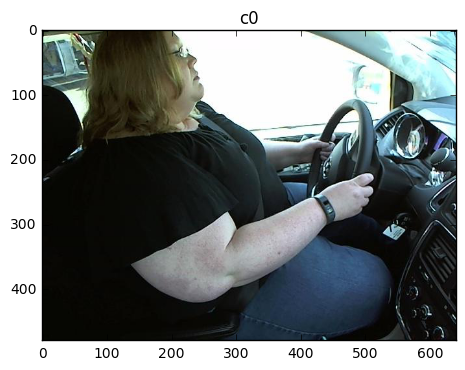

In [3]:
path = os.path.join( '..','capserver','data','imgs', 'train', 'c0', 'img_104.jpg')
import matplotlib.image as mpimg
img=mpimg.imread(path)
#resized = cv2.resize(img, (100, 80), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(img)
plt.show()

## Data Preprocessing

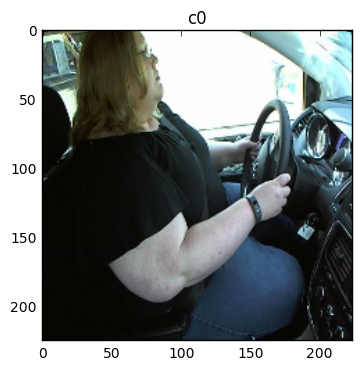

In [4]:
resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(resized)
plt.show()

In [3]:
def get_im_cv2_resize(path, img_rows, img_cols, color_type=1):
  
    if color_type == 1:
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows), cv2.INTER_LINEAR)
    return resized

## Create training Set

Load the data and resize to create training set.

In [4]:
def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, color_type)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float16')
    #train_data /= 255
    mean_pixel = [103.939,116.779,123.68]
    print('Substract mean')
    train_data[:, :, :, 0] -= mean_pixel[0]   
    train_data[:, :, :, 1] -= mean_pixel[1]
    train_data[:, :, :, 2] -= mean_pixel[2]
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers


In [5]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def get_driver_data():
    dr = dict()
    path = os.path.join( '..','capserver','data', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [6]:
img_rows, img_cols = 224, 224
batch_size = 128
nb_epoch = 25
random_state = 51

use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 3
 
train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)

Restore train from cache!
Substract mean
Train shape: (22424, 224, 224, 3)
22424 train samples


## Training Model Design

In [20]:
model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)
 
model_resnet50_conv.summary()

input = Input(shape=(224,224,3),name = 'image_input')

#Use the generated model 
output_resnet50_conv = model_resnet50_conv(input)

#Add the fully-connected layers 
x = Flatten()(output_resnet50_conv)
#x = Dropout(0.3)(x)
x = Dense(10, activation='softmax', name='predictions')(x)

#Create your own model 
model = Model(input=input, output=x)

model.summary()
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2D (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256                                          
___________________________________________________________________________________________

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  app.launch_new_instance()


In [3]:
#from keras.applications.resnet50 import ResNet50
def train_model():
    model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)
 
    input = Input(shape=(224,224,3),name = 'image_input')

    #Use the generated model 
    output_resnet50_conv = model_resnet50_conv(input)

    #Add the fully-connected layers 
    x = Flatten()(output_resnet50_conv)
    #x = Dropout(0.3)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    #Create your own model 
    model = Model(input=input, output=x)
   
    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Model Visualization

/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


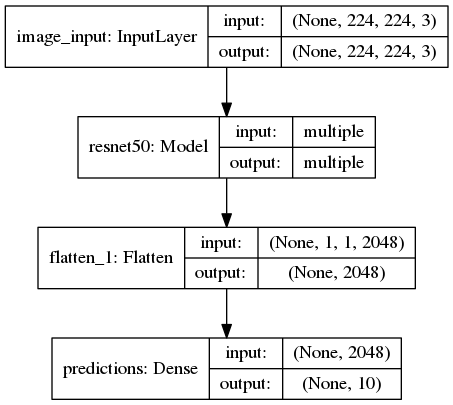

In [4]:
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import Image, SVG
model=train_model()
plot_model(model,show_shapes=True)
Image(filename = 'model.png')

## Train Model and Save

In [8]:
np.random.seed(2016)
batch_size = 32
num_fold=0
nfolds=5
restore_from_last_checkpoint = 1

#X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.2, random_state=42)

kf = KFold(train_data.shape[0], n_folds=nfolds, shuffle=True,random_state=random_state)

for train, test in kf:
    model = train_model()
    #X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.125, random_state=42)
    
    num_fold += 1
    print('Start KFold number {} from {}'.format(num_fold, nfolds))
    print('Split train: ', len(train_data[train]), len(train_target[train]))
    print('Split valid: ', len(train_data[test]), len(train_target[test]))
    #print('Train drivers: ', unique_list_train)
    #print('Test drivers: ', unique_list_valid)
    
    kfold_weights_path = os.path.join('cache', 'weights_kfold_vgg16_' + str(num_fold) + '.h5')
    if not os.path.isfile(kfold_weights_path) or restore_from_last_checkpoint == 0:
            callbacks = [
                #EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
                EarlyStopping(monitor='val_loss', patience=10, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
                #ReduceLROnPlateau(monitor='cal_loss',factor=0.5,patience=5,min_lr=0.0001)
            ]
            log=model.fit(train_data[train], train_target[train], batch_size=batch_size, nb_epoch=40,
                  shuffle=True, verbose=1, validation_data=(train_data[test],train_target[test]),
                  callbacks=callbacks)
            

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


Start KFold number 1 from 5
Split train:  17939 17939
Split valid:  4485 4485


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 17939 samples, validate on 4485 samples
Epoch 1/40
17939/17939 [==============================] - 688s - loss: 0.2347 - acc: 0.9306 - val_loss: 0.1212 - val_acc: 0.9625
Epoch 2/40
17939/17939 [==============================] - 670s - loss: 0.0524 - acc: 0.9853 - val_loss: 1.2025 - val_acc: 0.7478
Epoch 3/40
17939/17939 [==============================] - 672s - loss: 0.0570 - acc: 0.9827 - val_loss: 0.0776 - val_acc: 0.9764
Epoch 4/40
17939/17939 [==============================] - 670s - loss: 0.0225 - acc: 0.9934 - val_loss: 0.1435 - val_acc: 0.9657
Epoch 5/40
17939/17939 [==============================] - 670s - loss: 0.0428 - acc: 0.9870 - val_loss: 0.1501 - val_acc: 0.9545
Epoch 6/40
17939/17939 [==============================] - 669s - loss: 0.0147 - acc: 0.9958 - val_loss: 0.3736 - val_acc: 0.9050
Epoch 7/40
17939/17939 [==============================] - 672s - loss: 0.0276 - acc: 0.9922 - val_loss: 0.0218 - val_acc: 0.9933
Epoch 8/40
17939/17939 [========================

## Save Model

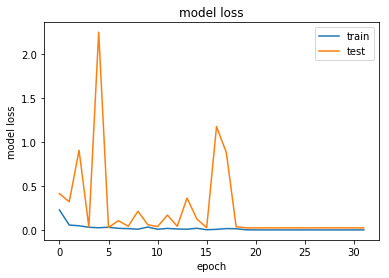

In [9]:
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title('model loss')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train','test','val_train','val_test'], loc='upper right')
plt.show()

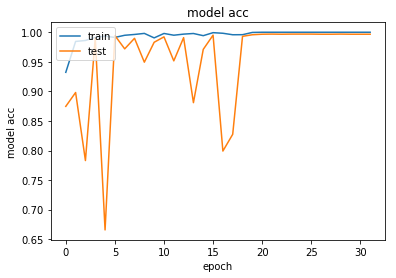

In [10]:
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('model acc')
plt.ylabel('model acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
import matplotlib
matplotlib.get_backend()

## Create Submission

In [7]:
img_rows, img_cols = 224, 224
batch_size = 32
nb_epoch = 25
random_state = 51

use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 3

In [9]:
def load_test(part):
    path = os.path.join('..','capserver','data', 'imgs', 'test', '*.jpg')
    files = sorted(glob.glob(path))
    ch = split_list(files, 5)

    X_test = []
    X_test_id = []
    print('Start image: ' + str(ch[part][0]))
    print('Last image: ' + str(ch[part][-1]))
    for fl in ch[part]:
        flbase = os.path.basename(fl)
        img = get_im_cv2_resize(fl, img_rows, img_cols, 3)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

In [8]:
def read_and_normalize_test_data(part):
    start_time = time.time()
    cache_path = os.path.join('cache', 'test_r_' + str(224) +
                              '_c_' + str(224) +
                              '_part_' + str(part) +
                              '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(part)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache [{}]!'.format(part))
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    

    test_data = test_data.astype('float16')
    #test_data /=225
    mean_pixel = [103.939, 116.779, 123.68]
    print('Substract mean')
    test_data[:, :, :, 0] -= mean_pixel[0]   
    test_data[:, :, :, 1] -= mean_pixel[1]
    test_data[:, :, :, 2] -= mean_pixel[2]
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_id


In [10]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

In [11]:
def split_list(l, wanted_parts=1):
    length = len(l)
    return [l[i*length // wanted_parts: (i+1)*length // wanted_parts] for i in range(wanted_parts)]

def append_chunk(main, part):
    for p in part:
        main.append(p)
    return main

In [12]:
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

In [13]:

def run_cross_validation_process_test(nfolds = 5):
    batch_size = 16
    num_fold = 0
    yfull_test = []
    test_id = []

    for i in range(nfolds):
        model = train_model()
        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        kfold_weights_path = os.path.join('cache', 'weights_kfold_vgg16_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)

        kfold_test_validation_path = os.path.join('cache', 'test_kfold_vgg16_' + str(num_fold) + '.pickle.dat')
        kfold_test_ids_path = os.path.join('cache', 'test_kfold_vgg16_ids.pickle.dat')
        if not os.path.isfile(kfold_test_validation_path):
            test_prediction = []
            for part in range(5):
                print('Reading test data part {}...'.format(part))
                test_data_chunk, test_id_chunk = read_and_normalize_test_data(part)
                test_prediction_chunk = model.predict(test_data_chunk, batch_size=batch_size, verbose=1)
                test_prediction = append_chunk(test_prediction, test_prediction_chunk)
                if i == 0:
                    test_id = append_chunk(test_id, test_id_chunk)
            cache_data(test_prediction, kfold_test_validation_path)
            if i == 0:
                cache_data(test_id, kfold_test_ids_path)
        else:
            print('Restore data from cache...')
            test_prediction = restore_data(kfold_test_validation_path)
            if i == 0:
                test_id = restore_data(kfold_test_ids_path)

        yfull_test.append(test_prediction)

    test_res = merge_several_folds_mean(yfull_test, nfolds)
    info_string = 'loss_' \
                + '_r_' + str(224) \
                + '_c_' + str(224) \
                + '_folds_' + str(nfolds)
    suffix = info_string + '_' + str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M"))
    cache_data((yfull_test, test_id), os.path.join("subm", "full_array_" + suffix + ".pickle.dat"))
    create_submission(test_res, test_id, info_string)
    # Store debug submissions
    for i in range(nfolds):
        info_string1 = info_string + '_debug_' + str(i)
        create_submission(yfull_test[i], test_id, info_string1)


In [18]:
run_cross_validation_process_test(nfolds = 5)

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


Start KFold number 1 from 5
Reading test data part 0...
Start image: ../capserver/data/imgs/test/img_1.jpg
Last image: ../capserver/data/imgs/test/img_26429.jpg
Substract mean
Test shape: (15945, 224, 224, 3)
15945 test samples
Read and process test data time: 169.97 seconds
15945/15945 [==============================] - 214s   
Reading test data part 1...
Start image: ../capserver/data/imgs/test/img_2643.jpg
Last image: ../capserver/data/imgs/test/img_44886.jpg
Substract mean
Test shape: (15945, 224, 224, 3)
15945 test samples
Read and process test data time: 163.28 seconds
15945/15945 [==============================] - 209s   
Reading test data part 2...
Start image: ../capserver/data/imgs/test/img_44887.jpg
Last image: ../capserver/data/imgs/test/img_63261.jpg
Substract mean
Test shape: (15945, 224, 224, 3)
15945 test samples
Read and process test data time: 163.53 seconds
15945/15945 [==============================] - 209s   
Reading test data part 3...
Start image: ../capserver/da

# Sample Prediction

In [40]:
def predict(path):

    X_test = []
    X_test_id = []


    #fl = os.path.basename(path)
    img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)

    X_test.append(resized)
    #X_test_id.append(flbase)
    
    test_data = np.array(X_test, dtype=np.uint8)
    test_data = test_data.astype('float16')   
    mean_pixel = [103.939, 116.779, 123.68]
    print('Substract mean')
    test_data[:, :, :, 0] -= mean_pixel[0]   
    test_data[:, :, :, 1] -= mean_pixel[1]
    test_data[:, :, :, 2] -= mean_pixel[2]
    model=train_model()
    kfold_weights_path = os.path.join('cache', 'weights_kfold_vgg16_' + str(1) + '.h5')
    model.load_weights(kfold_weights_path)

    test_prediction = model.predict(test_data,verbose=1)
    result=str(np.argmax(test_prediction))
    return img,result


In [41]:
path1 = os.path.join('..','capserver','data', 'imgs', 'test', 'img_1.jpg')
img,result=predict(path1)

Substract mean


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


1/1 [==============================] - 3s


In [42]:
result

'5'

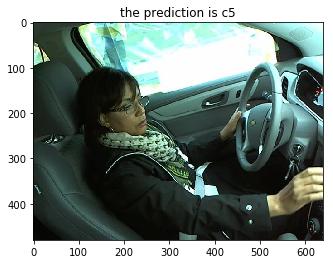

In [43]:
plt.title('the prediction is c'+result)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


1/1 [==============================] - 3s


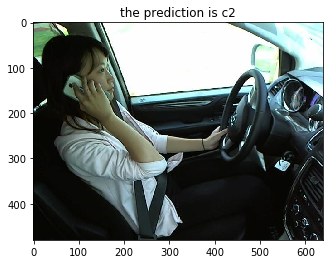

In [44]:
path2 = os.path.join('..','capserver','data', 'imgs', 'test', 'img_2.jpg')
img,result=predict(path2)
plt.title('the prediction is c'+result)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()